In [ ]:
import os
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
import numpy as np


In [ ]:
#mounting google drive to load data 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


AxesImage(54,36;334.8x217.44)
Image size: (80, 50, 3)
120


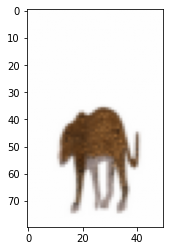

In [ ]:
#Loading the images and storing into a list by cropping and 
#resizing to (80,50) to maintain the aspect ratio of original image data
import os
from skimage.transform import resize
from skimage.util import crop
#the image path from google drive
path ="/content/drive/My Drive/Synthetic_Leopard_Circle"
imageDirectory=os.listdir(path) 

depth=[]
allImg_list=[]
for img in imageDirectory:
  if "col" in img:
    image=(io.imread(os.path.join(path,img))) 
    imgCr=crop(image, ((50, 100), (50, 100), (0,0)), copy=False)
    img_resized = resize(imgCr, (80, 50))
    allImg_list.append(img_resized) 
  else:
      depth.append("depth File not needed")

print(plt.imshow(allImg_list[0]))
print("Image size:", allImg_list[0].shape)

#Converting img list into array
allImg_list=np.array(allImg_list)
print(allImg_list.shape[0])

###splitting the images into train,valid and test split

In [ ]:

import numpy as np
splitTrain=list(range(90))
splitValid=list(range(90, 100))
splitTest=list(range(100,120))
print("Size of Train split:",len(splitTrain))
print("Size of Validation split:",len(splitValid))
print("Size of Test split:",len(splitTest))


Size of Train split: 90
Size of Validation split: 10
Size of Test split: 20


### Pairing the images into Train, valid ans Test pairs along with their labels

In [ ]:
image_pairsTrain=[]
image_pairsValid=[]
image_pairsTest=[]
angle_DiffTrain=[]
angle_DiffValid=[]
angle_DiffTest=[]
for i in range (0,allImg_list.shape[0]):
    
    for j in range(-15,16):
      image=allImg_list[i]
      nextImage=allImg_list[(i+j)%allImg_list.shape[0]]
      img=np.concatenate((image, nextImage),axis=2)
      angularDif=j*3
      if i in splitTrain:
        image_pairsTrain.append(img)
        angle_DiffTrain.append(angularDif)
      
      elif i in splitValid:
        image_pairsValid.append(img)
        angle_DiffValid.append(angularDif)
      
      else:
        image_pairsTest.append(img)
        angle_DiffTest.append(angularDif)

            

### Encoding the labels

In [ ]:
# import LabelEncoder 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# Instatniate LabelEncoder
le = LabelEncoder()
# LabelEncode the labels
yTrain= le.fit_transform(angle_DiffTrain)
yValid= le.fit_transform(angle_DiffValid)
yTest= le.fit_transform(angle_DiffTest)

#converting labels to categorical
yTrain = to_categorical(yTrain)
yValid= to_categorical(yValid)
yTest = to_categorical(yTest) 
print("ytrain shape:", yTrain.shape)
print("Train Labels:",len(yTrain))
print("Validation labels:", len(yValid))
print("Test Labels:", len(yTest))
print("class labels in yTrain:", np.unique(angle_DiffTrain))

ytrain shape: (2790, 31)
Train Labels: 2790
Validation labels: 310
Test Labels: 620
class labels in yTrain: [-45 -42 -39 -36 -33 -30 -27 -24 -21 -18 -15 -12  -9  -6  -3   0   3   6
   9  12  15  18  21  24  27  30  33  36  39  42  45]


In [ ]:
#converting Train data into numpy array
xTrain=np.array(image_pairsTrain)
print("Shape of image pairs array:", xTrain.shape)
xValid=np.array(image_pairsValid)
xTest=np.array(image_pairsTest)
print("Numebr of train pairs for train split with start position 90 :", len(xTrain))
print("Number of Valiadtion pairs for valid split with start position 10 :", len(xValid))
print("Number of Test pairs for test split with start position 20 :", len(xTest))

Shape of image pairs array: (2790, 80, 50, 6)
Numebr of train pairs for train split with start position 90 : 2790
Number of Valiadtion pairs for valid split with start position 10 : 310
Number of Test pairs for test split with start position 20 : 620


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Sequential

#define model
my_model3 =Sequential()

# 1st block 
my_model3.add(Conv2D(32, (3, 3), activation='relu', padding='same', 
                    input_shape=(80, 50, 6)))
my_model3.add(BatchNormalization())
my_model3.add(MaxPooling2D((2, 2), padding='same'))

# Second block
my_model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
my_model3.add(BatchNormalization())
my_model3.add(MaxPooling2D((2, 2), padding='same'))

#3rd block 
my_model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
my_model3.add(BatchNormalization())
my_model3.add(MaxPooling2D((2, 2), padding='same'))

# this converts our 3D feature maps to 1D feature vectors
my_model3.add(Flatten())
# fully connected layer
my_model3.add(Dense(512, activation='relu'))
my_model3.add(BatchNormalization())
#my_model3.add(Dropout(0.5))
# make predictions
my_model3.add(Dense(31, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
my_model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 80, 50, 32)        1760      
_________________________________________________________________
batch_normalization_4 (Batch (None, 80, 50, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 25, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 25, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 40, 25, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 13, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 13, 128)      

In [ ]:
#Creating dataGenerator
import tensorflow as tf
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
# use early stopping to optimally terminate training through callbacks
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=155)

# save best model automatically
mc= ModelCheckpoint('yourdirectory/CNN2D_model.h5', monitor='val_loss', 
                    mode='min', verbose=1, save_best_only=True)
cb_list=[es,mc]

# compile model 
my_model3.compile(optimizer='adam', loss='categorical_crossentropy', 
                 metrics=['accuracy'])
#categorical_crossentropy

In [ ]:
history = my_model3.fit_generator(
        datagen.flow(xTrain, yTrain, batch_size=30),
        
        epochs=155,
        validation_data=datagen.flow(xValid, yValid, batch_size=30),
        callbacks=cb_list)


Epoch 1/155
11/93 [==>...........................] - ETA: 0s - loss: 0.0092 - accuracy: 1.0000

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2790, 80, 50, 6) (6 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (310, 80, 50, 6) (6 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


89/93 [===========================>..] - ETA: 0s - loss: 0.0111 - accuracy: 0.9981
Epoch 00001: val_loss did not improve from 5.39866
93/93 [==============================] - 1s 11ms/step - loss: 0.0118 - accuracy: 0.9978 - val_loss: 1618.3325 - val_accuracy: 0.0355
Epoch 2/155
88/93 [===========================>..] - ETA: 0s - loss: 0.0100 - accuracy: 0.9981
Epoch 00002: val_loss did not improve from 5.39866
93/93 [==============================] - 1s 10ms/step - loss: 0.0101 - accuracy: 0.9982 - val_loss: 6971.3477 - val_accuracy: 0.0419
Epoch 3/155
89/93 [===========================>..] - ETA: 0s - loss: 0.0065 - accuracy: 0.9996
Epoch 00003: val_loss did not improve from 5.39866
93/93 [==============================] - 1s 10ms/step - loss: 0.0065 - accuracy: 0.9996 - val_loss: 1381.5142 - val_accuracy: 0.0355
Epoch 4/155
90/93 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9978
Epoch 00004: val_loss did not improve from 5.39866
93/93 [======================

In [ ]:

train_accCNN=history.history['accuracy']
val_accCNN=history.history['val_accuracy']
print("Train accuracy:", train_accCNN[epochs-1])
print("Validation Accuracy:", val_accCNN[epochs-1])
test_scoresCNN=my_model3.evaluate(xTest, yTest, verbose=2)
print("Accuracy on Test set:", test_scoresCNN[1])

Train accuracy: 1.0
Validation Accuracy: 0.04193548485636711
20/20 - 0s - loss: 1307092.3750 - accuracy: 0.0323
Accuracy on Test set: 0.032258063554763794


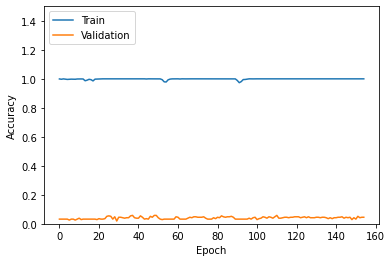

In [ ]:
# plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0,1.5])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("CNN2D.png", dpi=300)


### Analysis:

1. I have used optimizer like SGD() that did not perform well as the train accuarcy was below 0.40. But, after using adam the accuarcy was improved to 0.70
2. The keras seqential model with less than 4 million parameters does not actually perform well. The accuracy was incraesed to above 0.50 after adding 3rd convoluitonal block. 
3. However, Batch Normalization works better as a regularization method than dropout for this dataset.
3. The model accuracy increases slightly  with further training and increase in the numebr of epochs
4. As it is seen the model accuarcy on the tarining set is 1 whereas the accuracy on valid and test set is at 0.0419 and 0.0322 respectively. So, model did not work well on validation and test data which is evident in the learning curve.



# Section 4: Regression Network

### Mapping the class labels in between -1 to 1 

In [ ]:
#preparing labels for regressor model and storing the new labels in yTrainN, yValidN, yTestN
import numpy as np
yTrainN=np.array(angle_DiffTrain)
yValidN=np.array(angle_DiffValid)
yTestN=np.array(angle_DiffTest)

#Mapping the labels in between -1 to 1 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
yTrainN=scaler.fit_transform(yTrainN.reshape(-1, 1))
yValidN=scaler.fit_transform(yValidN.reshape(-1, 1))
yTestN = scaler.fit_transform(yTestN.reshape(-1, 1))
print(" ytrain shape:", yTrainN.shape)
print("Checking the mapped class labels in yTrain:", np.unique(yTrainN))

 ytrain shape: (2790, 1)
Checking the mapped class labels in yTrain: [-1.         -0.93333333 -0.86666667 -0.8        -0.73333333 -0.66666667
 -0.6        -0.53333333 -0.46666667 -0.4        -0.33333333 -0.26666667
 -0.2        -0.13333333 -0.06666667  0.          0.06666667  0.13333333
  0.2         0.26666667  0.33333333  0.4         0.46666667  0.53333333
  0.6         0.66666667  0.73333333  0.8         0.86666667  0.93333333
  1.        ]


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Sequential

#define model
regressor_model =Sequential()

# 1st block 
regressor_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', 
                    input_shape=(80, 50, 6)))
regressor_model.add(BatchNormalization())
regressor_model.add(MaxPooling2D((2, 2), padding='same'))

# Second block
regressor_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
regressor_model.add(BatchNormalization())
regressor_model.add(MaxPooling2D((2, 2), padding='same'))

#3rd block 
regressor_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
regressor_model.add(BatchNormalization())
regressor_model.add(MaxPooling2D((2, 2), padding='same'))

# model.add(dropout())  # this converts our 3D feature maps to 1D feature vectors
regressor_model.add(Flatten())
# fully connected layer
regressor_model.add(Dense(512, activation='relu'))
regressor_model.add(BatchNormalization())
# make predictions
regressor_model.add(Dense(1, activation='tanh'))

# Show a summary of the model. Check the number of trainable parameters
regressor_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 80, 50, 32)        1760      
_________________________________________________________________
batch_normalization_29 (Batc (None, 80, 50, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 25, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 25, 64)        18496     
_________________________________________________________________
batch_normalization_30 (Batc (None, 40, 25, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 13, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 13, 128)      

In [ ]:
# use early stopping to optimally terminate training through callbacks
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=153)

# save best model automatically
mc= ModelCheckpoint('yourdirectory/regressorCNN_model.h5', monitor='val_loss', 
                    mode='min', verbose=1, save_best_only=True)
cb_list=[es,mc]
#00001
from keras import optimizers
optimizer_new=optimizers.RMSprop(lr=0.0005) 
regressor_model.compile(optimizer=optimizer_new, loss='mse', 
                 metrics=['mse'])

In [ ]:
#Creating dataGenerator 
import tensorflow as tf
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

In [ ]:
history = regressor_model.fit(
        xTrain, yTrainN, 
        batch_size=30,
        epochs=160,
        validation_data=(xValid, yValidN),
        callbacks=cb_list)

Epoch 1/160
89/93 [===========================>..] - ETA: 0s - loss: 0.3297 - mse: 0.3297
Epoch 00001: val_loss did not improve from 0.03140
93/93 [==============================] - 1s 11ms/step - loss: 0.3285 - mse: 0.3285 - val_loss: 0.6917 - val_mse: 0.6917
Epoch 2/160
91/93 [============================>.] - ETA: 0s - loss: 0.2876 - mse: 0.2876
Epoch 00002: val_loss did not improve from 0.03140
93/93 [==============================] - 1s 10ms/step - loss: 0.2887 - mse: 0.2887 - val_loss: 0.9606 - val_mse: 0.9606
Epoch 3/160
90/93 [============================>.] - ETA: 0s - loss: 0.2656 - mse: 0.2656
Epoch 00003: val_loss did not improve from 0.03140
93/93 [==============================] - 1s 10ms/step - loss: 0.2649 - mse: 0.2649 - val_loss: 0.5375 - val_mse: 0.5375
Epoch 4/160
91/93 [============================>.] - ETA: 0s - loss: 0.2347 - mse: 0.2347
Epoch 00004: val_loss did not improve from 0.03140
93/93 [==============================] - 1s 10ms/step - loss: 0.2351 - mse: 

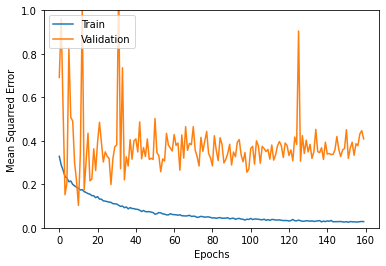

In [ ]:
# plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.ylim([0,1])
plt.ylabel('Mean Squarred Error')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("RegressorCNN2.png", dpi=300)

In [ ]:
train_mseReg=history.history['mse']
val_mseReg=history.history['val_mse']
test_scoresReg=regressor_model.evaluate(xTest, yTestN, verbose=2)
print("MSE on Train set:", train_mseReg[153-1])
print("MSE on Validation set:", val_mseReg[153-1])
print("MSE on Test set::", test_scoresReg[0])

20/20 - 0s - loss: 0.4839 - mse: 0.4839
MSE on Train set: 0.028874864801764488
MSE on Validation set: 0.36613020300865173
MSE on Test set:: 0.4839111268520355


## Analysis:
1. I have tried using sigmoid and linear function as activation but it did not perform well as the network is being trained to output a floating point value which ranges between -1 to 1.So, tanh is used as it allows the outputs to stay in range (-1,1).
2. Neither adam nor sgd worked on this  model but RMSprop with learning rate of 0.00001 reduced the mse of train to 0.0320 which was reduced further with further training of the model with more epochs. 
3. As it can be seen that the mse for both valid and test data did not decrease from 0.031. From learning curve, it is visible that the mean squarred errro did not change remarkably which could be due to the outputs of the model having values of negative floating points. Also, label encoder was not used as the model is expected to predict negative floating point values.

# Section 5: Transfer Learning with VGG16

Preparing data for VGG16

AxesImage(54,36;334.8x217.44)
(80, 50)
120


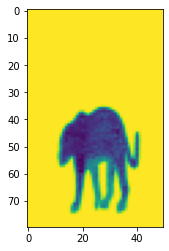

In [ ]:
import os
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.util import crop
path ="/content/drive/My Drive/Synthetic_Leopard_Circle"
imageDirectory=os.listdir(path) 

allImg_listN=[]
depth=[]

for img in imageDirectory:
  if "col" in img:
    image=(io.imread(os.path.join(path,img))) 
    imgCr=crop(image, ((50, 100), (50, 100), (0,0)), copy=False)
    img_gray = rgb2gray(imgCr)
    img_resized = resize(img_gray, (80, 50))
    allImg_listN.append(img_resized) 
  else:
        depth.append("depth File not needed")

print(plt.imshow(allImg_listN[0]))
print(allImg_listN[0].shape)

#converting the imagelist to numpy array
allImg_listN=np.array(allImg_listN)
print(allImg_listN.shape[0])

### Creating image pairs width depth 3 from grayscale images by adding a blank channel 

In [ ]:
from numpy import array, dstack
#defining data split ranges into Train(0-90), Valid(90-100), Test(100-120)
import numpy as np
splitTrain=list(range(90))
splitValid=list(range(90, 100))
splitTest=list(range(100,120))

#initializing train, valid and test image data and label lists
image_pairsTrainM=[]
image_pairsValidM=[]
image_pairsTestM=[]
angle_DiffTrain=[]
angle_DiffValid=[]
angle_DiffTest=[]

#initializing a blank array of 0 to add a blank channel in the image pair
blank_channel=array([0] * 80 * 50) 
blank_channel= blank_channel.reshape(80, 50)

for i in range (0,allImg_listN.shape[0]):
    
    for j in range(-15,16):
      image=allImg_listN[i]
      nextImage=allImg_listN[(i+j)%allImg_listN.shape[0]]
      img=np.dstack((image, nextImage, blank_channel ))
      angularDif=j*3
      if i in splitTrain:
        image_pairsTrainM.append(img)
        angle_DiffTrain.append(angularDif)
      
      elif i in splitValid:
        image_pairsValidM.append(img)
        angle_DiffValid.append(angularDif)
      
      else:
        image_pairsTestM.append(img)
        angle_DiffTest.append(angularDif)


In [ ]:
#converting Train data into numpy array
xTrainN=np.array(image_pairsTrainM)
print("size of image pairs:", xTrainN.shape)
xValidN=np.array(image_pairsValidM)
xTestN=np.array(image_pairsTestM)

print("Total train pairs for train split with start position 90:",len(xTrainN))
print("Total valid pairs for valid split with start position 10:",len(xValidN))
print("Total test pairs for test split with start position 20:",len(xTestN))

size of image pairs: (2790, 80, 50, 3)
Total train pairs for train split with start position 90: 2790
Total valid pairs for valid split with start position 10: 310
Total test pairs for test split with start position 20: 620


In [ ]:
import tensorflow
from tensorflow.keras.applications import vgg16
# Init the VGG model
vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(80, 50, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
from keras import applications 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Sequential
# Freeze all the layers
for layer in vgg16_model.layers[:-2]:

   layer.trainable = False

# Create the model
vgg_model = Sequential()
# Add the vgg convolutional base model
vgg_model.add(vgg16_model)


vgg_model.add(Conv2D(128, (1, 1), activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(MaxPooling2D((2, 2), padding='same'))

# flatten features
vgg_model.add(Flatten())
vgg_model.add(Dense(1024, activation=tensorflow.keras.layers.LeakyReLU(alpha=0.3))) 
vgg_model.add(BatchNormalization())
vgg_model.add(Dense(1, activation='tanh'))
# Show a summary of the model. 
vgg_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 1, 512)         14714688  
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 2, 1, 128)         65664     
_________________________________________________________________
batch_normalization_58 (Batc (None, 2, 1, 128)         512       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 1024)              132096    
_________________________________________________________________
batch_normalization_59 (Batc (None, 1024)            

In [ ]:
#Creating dataGenerator 
import tensorflow as tf
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

In [ ]:
#parameter change optimizer
# use early stopping to optimally terminate training through callbacks
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=54)

# save best model automatically
mc= ModelCheckpoint('yourdirectory/VGG_model25M.h5', monitor='val_loss', 
                    mode='min', verbose=1, save_best_only=True)
cb_list=[es,mc]

from keras import optimizers
optimizer_new=optimizers.RMSprop(lr=0.0001)
# compile model 
vgg_model.compile(optimizer=optimizer_new, loss='mse', 
                 metrics=['mse'])

In [ ]:
#this was run with no conv layer added without data generator added The output of basic model
history = vgg_model.fit_generator(
        datagen.flow(xTrainN, yTrainN, batch_size=30), 
        epochs=150,
        validation_data=val_datagen.flow(xValidN, yValidN, batch_size=10),
        callbacks=cb_list)


Epoch 1/150
93/93 [==============================] - ETA: 0s - loss: 0.0312 - mse: 0.0312
Epoch 00001: val_loss improved from inf to 0.03417, saving model to yourdirectory/VGG_model25M.h5
93/93 [==============================] - 2s 25ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 2/150
91/93 [============================>.] - ETA: 0s - loss: 0.0312 - mse: 0.0312
Epoch 00002: val_loss did not improve from 0.03417
93/93 [==============================] - 2s 22ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.3466 - val_mse: 0.3466
Epoch 3/150
91/93 [============================>.] - ETA: 0s - loss: 0.0312 - mse: 0.0312
Epoch 00003: val_loss improved from 0.03417 to 0.03274, saving model to yourdirectory/VGG_model25M.h5
93/93 [==============================] - 2s 23ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 4/150
91/93 [============================>.] - ETA: 0s - loss: 0.0312 - mse: 0.0312
Epoch 00004: val_loss did not

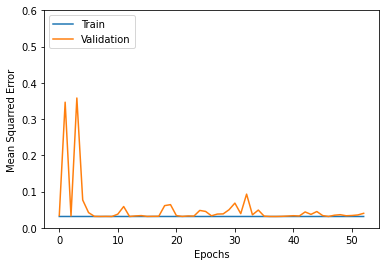

In [ ]:
# plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.ylim([0,0.6])
plt.ylabel('Mean Squarred Error')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("VGGModel1.png", dpi=300)

In [ ]:
train_mseVGG=history.history['mse']
val_mseVGG=history.history['val_mse']
print("MSE on Train set:", train_mseVGG[53-1])
print("MSE on Validation set:", val_mseVGG[53-1])
test_scoresVGG=vgg_model.evaluate(xTestN, yTestN, verbose=2)
print("MSE on Test set:", test_scoresVGG[1])

MSE on Train set: 0.03121822141110897
MSE on Validation set: 0.03993906080722809
20/20 - 0s - loss: 0.0399 - mse: 0.0399
MSE on Test set: 0.03993600606918335


# Implementation analysis

1. VGG16 base model was loaded keeping last two layers unfrozen. Addition of an extra convoluitonal layer before using Flatten helps in reducing the number of parameters of the model.Batch normalization works well as a regularization technique. Without the extra conv layer and batch normalisation, the mse was too high. So, vgg16 did not take more than 5 or 6 minutes to finish training. 
2.  Use of LeakyReLU instead of relu in the second last dense layer improved the model performance slightly.
3. With adam as an optimzer the model's train mse was above 0.3.  Afterwards, RMSProp with a learning rate of 0.0001 was used which reduced the mse remarkably. The train and valid mse was declined to a stable state of 0.031 or 0.0377 after several consecutive training of the model with learning rate of 0.0001. The mse on the test dataset did  not also improve well.
4.Although, it was expected that the mse will be decreased remarkably after using a vgg16 model. But it did not work since greyscale image pairs are used instead of RGB which again were stacked depthwise leaving the last channel blank. Vgg16 which is pretrained on imagenet does not seem to work on the greyscale image pairs. 
4. Rotation_range=3 and horizontal flip was used initially as data augmentation techniues but only horizontal flip worked well on the dataset improving the model performance slightly.

#Section 5: Siamese Network 

### Preparing rgb images with depth 3 for siamese model

In [ ]:

#Taking input images with depth 3 Need to rescale the values
input1=xTrain[:,:,:,0:3]
input2=xTrain[:,:,:,3:6]
inputVal1=xValid[:,:,:,0:3]
inputVal2=xValid[:,:,:,3:6]
inputTest1=xTest[:,:,:,0:3]
inputTest2=xTest[:,:,:,3:6]

#rescaling the inputs image pixel
input1=input1/255.0
input2=input2/ 255.0
inputVal1= inputVal1/255.0
inputVal2=inputVal2 /255.0
inputTest1=inputTest1/255.0
inputTest2=inputTest2/255.0

print(input1.shape[1:])

(80, 50, 3)


### Building New Feature Extractor Model vgg16

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import preprocess_input


vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(80, 50, 3))

for layer in vgg16_model.layers[:]:    
    layer.trainable = False

#model = vgg_model()
model = vgg16_model

# add new classifier layersflat1 = Flatten()model.get_layer('block4_pool').output (model.get_layer('block4_pool').output)
flat1 = Flatten()(model.get_layer('block4_pool').output)
class1 = Dense(512, activation = 'relu')(flat1)   
batch1= BatchNormalization()(class1)
output = Dense(1, activation='linear')(batch1)
# define new model outputs=model.layers[-2].output
vgg16model1 = Model(inputs=model.inputs,outputs=output )
# summarize
vgg16model1.summary()


Model: "functional_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 80, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 12, 128)     

### Simamese Model

In [ ]:
#xTrainN.shape[1:]
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Activation
from keras.layers import concatenate
#initializing input size
img_a_in = Input(shape = input1.shape[1:] , name = 'ImageA_Input')
img_b_in = Input(shape = input1.shape[1:], name = 'ImageB_Input')

#extracting featuers for two images from the vgg16model 
img_a_feat = vgg16model(img_a_in)
img_b_feat = vgg16model(img_b_in)

#concatenating thmze features and feeding it to the model
merged_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
merged_features= Flatten()(merged_features)
newLayer = Dense(32, activation = 'relu')(merged_features)
newLayer = BatchNormalization()(newLayer)
newLayer = Activation('relu')(newLayer)
newLayer = Dense(16, activation = 'relu')(newLayer)
newLayer = BatchNormalization()(newLayer)
newLayer = Activation('relu')(newLayer)
prediction = Dense(1, activation = 'linear', name='targets' )(newLayer)
siamese_model = Model(inputs = [img_a_in, img_b_in], outputs = [prediction], name = 'Siamese_Model')
siamese_model.summary()

Model: "Siamese_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       [(None, 80, 50, 3)]  0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       [(None, 80, 50, 3)]  0                                            
__________________________________________________________________________________________________
functional_15 (Functional)      (None, 1)            15505729    ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 2)            0           functional_15[34][0] 

In [ ]:
# use early stopping to optimally terminate training through callbacks
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=400)

# save best model automatically
mc= ModelCheckpoint('yourdirectory/simaese1.h5', monitor='val_loss', 
                    mode='min', verbose=1, save_best_only=True)
cb_list=[es,mc]
#lr=0.00005
from keras import optimizers
siamese_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.000005),
    loss=['mse'], 
    metrics=['mse'])

### Using the Labels that were mapped in between (-1,1) in section 4 and stored in yTrainN, yValidN, yTestN again

In [ ]:
siamese_model.fit(
        {"ImageA_Input": input1, "ImageB_Input": input2}, {"targets": yTrain},
        epochs=400,
        batch_size=32,
        validation_data=({"ImageA_Input": inputVal1, "ImageB_Input": inputVal2}, {"targets": yValid}),
    
        callbacks=cb_list )


Epoch 1/400
87/88 [============================>.] - ETA: 0s - loss: 0.0313 - mse: 0.0313
Epoch 00001: val_loss did not improve from 0.03222
88/88 [==============================] - 3s 35ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 29.4513 - val_mse: 29.4513
Epoch 2/400
87/88 [============================>.] - ETA: 0s - loss: 0.0313 - mse: 0.0313
Epoch 00002: val_loss did not improve from 0.03222
88/88 [==============================] - 3s 34ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 45.2087 - val_mse: 45.2087
Epoch 3/400
87/88 [============================>.] - ETA: 0s - loss: 0.0313 - mse: 0.0313
Epoch 00003: val_loss did not improve from 0.03222
88/88 [==============================] - 3s 34ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.1792 - val_mse: 0.1792
Epoch 4/400
87/88 [============================>.] - ETA: 0s - loss: 0.0313 - mse: 0.0313
Epoch 00004: val_loss did not improve from 0.03222
88/88 [==============================] - 3s 33ms/step - loss: 0.0313 - m

KeyboardInterrupt: ignored

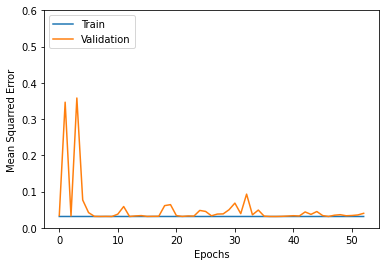

In [ ]:
# plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.ylim([0,0.6])
plt.ylabel('Mean Squarred Error')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("SiameseModel2.png", dpi=300)

In [ ]:
train_mseSimaese=history.history['mse']
val_mseSimaese=history.history['val_mse']
test_scoresSimaese=regressor_model.evaluate(xTest, yTest, verbose=2)
print("MSE on Train set:", train_mseSimaese[153-1])
print("MSE on Validation set:", val_mseSimaese[153-1])
print("MSE on Test set::", test_scoresSimaese[0])

## Analysis:
1. I have tried to load the model in seciton 5 but the newly loading vgg base network makes it convenient to build a feature extarctor.
2. The second last fully connected layer is used as the output layer in the vgg16 feature extractor model. A flatten layer is added after the last pooling layer of vgg16.
3. For 'tanh' as an activation function, train mse was 0.06 while val_mse was 12.4 which is unexpected. However, on the siamese model 'sigmoid' as the activation function works well.
4. with lr=0.0001 the mse was 0.032 val_mse=0.0319
